# Gymnasium integration
[Gymnasium](https://gymnasium.farama.org/) is an API standard for reinforcement learning with a diverse collection of reference environments. Stormvogel supports some integration with gymnasium. In particular, you can construct explicit models from the gymnasium environmnents under Gymnasium's [ToyText](https://gymnasium.farama.org/environments/toy_text/) (except Blackjack). 

## FrozenLake
Let us create one of these environments, called FrozenLake.
Our agent wants to get to the present. Currently, it just chooses a random action.

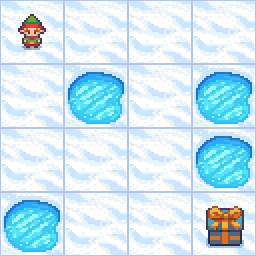

In [1]:
import gymnasium as gym
from stormvogel.extensions.gym_grid import *
from stormvogel import *
import IPython.display as ipd

env = gym.make("FrozenLake-v1", render_mode="rgb_array", is_slippery=False)  # Set `is_slippery=True` for stochastic behavior
filename = gymnasium_render_model_gif(env)
ipd.display(ipd.Image(filename))

We can convert it into an explicit MDP as follows. Each state has a label that relates to the coordinates of the tile.

In [2]:
sv_model = gymnasium_grid_to_stormvogel(env, GRID_ACTION_LABEL_MAP)
# GRID_ACTION_LABEL_MAP = {0: "←", 1: "↓", 2: "→", 3: "↑", 4: "pickup", 5: "dropoff"} (map between gymnasium action ids and labels)
vis = show(sv_model, layout=Layout("layouts/frozenlake.json"))

Output()

<IPython.core.display.Javascript object>

Output()

Now, let's do some model checking to calculate a strategy to solve the puzzle. We will tell the model checker to maximize the probability of getting to the target state (the present).

In [3]:
res = model_checking(sv_model, f'Pmax=? [F "target"]')
vis2 = show(sv_model, result=res, layout=Layout("layouts/frozenlake.json"))

Output()

Output()

Let's highlight the path to see what the scheduler is doing.

In [4]:
from stormvogel.simulator import simulate_path
path = simulate_path(sv_model, scheduler=res.scheduler, steps=20)
vis2.highlight_path(path, color="orange")

Alternatively, we can show what our scheduler does in the frozen lake environment itself.

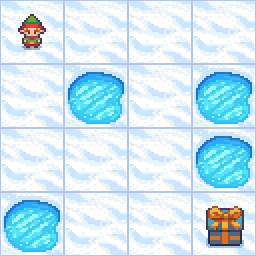

In [5]:
from stormvogel.extensions.gym_grid import *
gs = to_gymnasium_scheduler(sv_model, res.scheduler, GRID_ACTION_LABEL_MAP)
filename = gymnasium_render_model_gif(env, gs)
ipd.display(ipd.Image(filename))

We can also define a function to act as the scheduler on the model and convert it to a gymnasium scheduler. This one just keeps going in a loop...

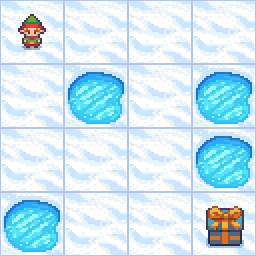

In [6]:
from stormvogel.model import Action

def my_scheduler(s: stormvogel.model.State):
    # "←" "↓" "→" "↑"
    if s.is_initial():
        return Action.create("→")
    env_id = int(s.labels[0])
    x,y = to_coordinate(env_id,env)
    if x < 2 and y == 0:
        return Action.create("→")
    elif x == 2 and y < 2:
        return Action.create("↓")
    elif x > 0 and y == 2:
        return Action.create("←")
    else:
        return Action.create("↑")

gs = to_gymnasium_scheduler(sv_model, my_scheduler, GRID_ACTION_LABEL_MAP)
filename = gymnasium_render_model_gif(env, gs)
ipd.display(ipd.Image(filename))

## CliffWalking
CliffWalking is a slightly more boring version of FrozenLake. You can apply the same principles that we just applied to FrozenLake.

In [7]:
import gymnasium as gym
from stormvogel.extensions.gym_grid import *

env = gym.make("CliffWalking-v0", render_mode="rgb_array")

In [8]:
sv_model = gymnasium_grid_to_stormvogel(env, GRID_ACTION_LABEL_MAP)
vis = show(sv_model, layout=Layout("layouts/cliffwalking.json"))

Output()

Output()

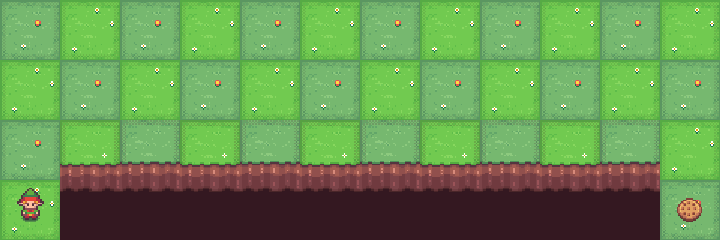

In [9]:
from stormvogel.model_checking import model_checking
res = model_checking(sv_model, f'Pmax=? [F "target"]')
gs = to_gymnasium_scheduler(sv_model, res.scheduler, GRID_ACTION_LABEL_MAP)
filename = gymnasium_render_model_gif(env, gs)
ipd.display(ipd.Image(filename))

## Taxi
In the Taxi scenario, a taxi has to pick up passengers and transport them to the hotel. The position of the target, passenger and taxi are chosen at random.

In [10]:
import gymnasium as gym
from stormvogel.extensions.gym_grid import *
env = gym.make("Taxi-v3", render_mode="rgb_array")  # Set `is_slippery=True` for stochastic behavior
sv_model = gymnasium_grid_to_stormvogel(env)
# This model is so big that it is better not to display it.
sv_model.summary()

'ModelType.MDP model with name None, 505 states, 7 actions, and 1005 distinct labels.'

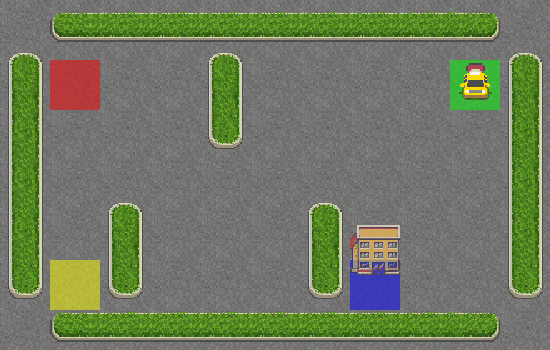

In [11]:
import IPython.display as ipd

target = get_target_state(env)
res = model_checking(sv_model, f'Rmax=? [S]')
gs = to_gymnasium_scheduler(sv_model, res.scheduler, GRID_ACTION_LABEL_MAP)
filename = gymnasium_render_model_gif(env, gs)
ipd.display(ipd.Image(filename))